Data and metadata available at http://www.ecad.eu

FILE FORMAT (MISSING VALUE CODE IS -9999):

01-06 SOUID: Source identifier

08-15 DATE : Date YYYYMMDD

17-21 TG   : mean temperature in 0.1 &#176;C

23-27 Q_TG : Quality code for TG (0='valid'; 1='suspect'; 9='missing')

This is the blended series of station GERMANY, BERLIN-TEMPELHOF (STAID: 2759).

Blended and updated with sources: 111448 127488 128124 

See file sources.txt and stations.txt for more info.

In [1]:
import pandas as pd

In [2]:
FILE_PATH = "/Users/elizavetabugaeva/Documents/Spiced/weekly_milestones/week_07/ECA_blended_custom/TG_STAID002759.txt"

df = pd.read_csv(
FILE_PATH,
#start from row 20
skiprows=19,
skipinitialspace = True,
#column #1 is dates in our original data 
parse_dates = [1]
)

In [4]:
df

,SOUID,DATE,TG,Q_TG
0,127488,1876-01-01,22,0
1,127488,1876-01-02,25,0
2,127488,1876-01-03,3,0
3,127488,1876-01-04,-58,0
4,127488,1876-01-05,-98,0
...,...,...,...,...
53776,111448,2023-03-27,34,0
53777,111448,2023-03-28,35,0
53778,111448,2023-03-29,66,0
53779,111448,2023-03-30,117,0


In [5]:
df.head()

,SOUID,DATE,TG,Q_TG
0,127488,1876-01-01,22,0
1,127488,1876-01-02,25,0
2,127488,1876-01-03,3,0
3,127488,1876-01-04,-58,0
4,127488,1876-01-05,-98,0


In [6]:
df.tail()

,SOUID,DATE,TG,Q_TG
53776,111448,2023-03-27,34,0
53777,111448,2023-03-28,35,0
53778,111448,2023-03-29,66,0
53779,111448,2023-03-30,117,0
53780,111448,2023-03-31,108,0


In [7]:
df_missing = df[df['Q_TG']==9]

In [8]:
df_missing['DATE'].min()

Timestamp('1945-04-25 00:00:00')

In [9]:
df_missing['DATE'].max()

Timestamp('1945-11-05 00:00:00')

In [16]:
#number of days with missing vallues
missing_days= (df_missing['DATE'].max() - df_missing['DATE'].min()).days +1
missing_days

195

In [19]:
#check is all missing days actually miss values
missing_days == df_missing.shape[0]

True

### Data Preprocessing

Missing days need to be inputed for the model to work

In [12]:
from dateutil.relativedelta import relativedelta

In [13]:
# reference years are all years 5 years before and  5 years after
reference_years = list(range(-5,6))
reference_years.remove(0)
# function for clean temperature values
def clean_temp(df,x):
    """
    returns a temperaure column in celcius with missing values imputed;
    imputation is done with the average of the temperautes on the same
    day over all the reference years; division by 10 for celcius value
    """
    # if missing value occurs
    if x['Q_TG']==9:
        # list reference dates
        reference_dates = [x['DATE']+relativedelta(years=y) for y in reference_years]
        # mean temperatue over the references dates
        temp_value = df[df['DATE'].isin(reference_dates)]['TG'].mean()
        # division by 10 to convert to celcius value
        return int(temp_value)/10
    # else just division by 10 to convert to celcius value
    return x['TG']/10

In [14]:
# create clean temperatutre column
df['TEMP'] = df.apply(
    lambda x: clean_temp(df,x),
    axis=1
)

In [17]:
#check that values are filled out
df[df['DATE']=='1945-07-25']

,SOUID,DATE,TG,Q_TG,TEMP
25407,127488,1945-07-25,-9999,9,20.6


### Train-test split

In [21]:
df.columns = df.columns.str.lower()
clean_df = df.set_index('date')[['temp']]

In [22]:
clean_df.head()

,temp
date,
1876-01-01,2.2
1876-01-02,2.5
1876-01-03,0.3
1876-01-04,-5.8
1876-01-05,-9.8


In [23]:
df.shape

(53781, 5)

In [31]:
train = clean_df[:'2022-12-31']
train.shape

(53691, 1)

In [32]:
test = clean_df['2023-01-01':]

In [34]:
test.shape

(90, 1)

In [35]:
train.to_csv('temp_train.csv')
test.to_csv('temp_test.csv')

In [36]:
#make a plot for past 5 years:

### Split train to noise and denoised

In [39]:
#import savitzky-golay filter
from scipy.signal import savgol_filter
import numpy as np

In [40]:
train['denoised']=savgol_filter(np.array(train['temp']),99,3, mode='nearest')

/var/folders/94/kqx3kf_s1k5_4_dh2y5hjqh80000gn/T/ipykernel_8467/3858972613.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['denoised']=savgol_filter(np.array(train['temp']),99,3, mode = 'nearest')


In [41]:
train['denoised']

date
1876-01-01   -0.659391
1876-01-02   -0.772946
1876-01-03   -0.858296
1876-01-04   -1.025494
1876-01-05   -1.151521
                ...   
2022-12-27    6.827954
2022-12-28    7.212065
2022-12-29    7.611574
2022-12-30    8.021626
2022-12-31    8.411407
Name: denoised, Length: 53691, dtype: float64

In [42]:
import matplotlib as mpl

<AxesSubplot:xlabel='date'>

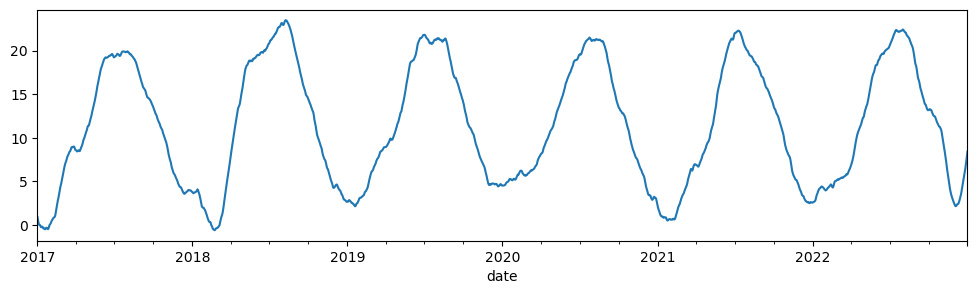

In [44]:
mpl.rc('figure',figsize=(12,3),dpi=100)
train['denoised']['2017-01-01':'2022-12-31'].plot()